In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
md_zip_ranges = [
    (20331,20331),
    (20335,20797),
    (20812,21930)
]

md_cities = pd.DataFrame(
    {'City':      ['Baltimore','Annapolis','Hagerstown','Frederick', 'Ft. Meade',
                   'Salisbury', 'Ocean City', 'Bethesda', 'Cumberland', 'College Park'],
     'Latitude':  [39.289452,    38.978132,  39.642500,  39.4141457, 39.1038739, 
                   38.3654624, 38.332159, 38.984372, 39.648437, 38.9897],
     'Longitude': [-76.613124,  -76.488142, -77.718646, -77.4092184,-76.742847, 
                   -75.5983227, -75.087294, -77.094755, -78.762657, -76.9378]
    }
)

cities_df = gpd.GeoDataFrame(
    md_cities, geometry=gpd.points_from_xy(md_cities.Longitude, md_cities.Latitude))

md_zips = ['%05d' % zipc for zip_range in md_zip_ranges
                     for zipc in range(zip_range[0],zip_range[1]+1)]

cases = pd.DataFrame(
    [[np.NaN,None] for _ in range(len(md_zips))],
    index=md_zips,
    columns=['cases', 'City']
)


# MD County COVID-19 Cases By Zip Code

In [3]:
zips_json = requests.get('https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/ZIPCodes_MD_1/FeatureServer/0/query?f=json&where=ProtectedCount%3E%3D0&returnGeometry=false&spatialRel=esriSpatialRelIntersects&outFields=*&orderByFields=ZIPCODE1%20asc&resultOffset=0&resultRecordCount=300&cacheHint=true')
current_cases_d = dict((x['attributes']['ZIPCODE1'],[x['attributes']['ProtectedCount'], 
                                                     x['attributes']['ZIPName']])
                        for x in zips_json.json()['features'])
current_cases = pd.DataFrame(
    current_cases_d.values(),
    index=current_cases_d.keys(),
    columns=['cases','City'])
current_cases

,cases,City
20601,55,Waldorf
20602,76,Waldorf
20603,116,Waldorf
20607,33,Accokeek
20613,48,Brandywine
...,...,...
21804,82,Salisbury
21811,20,Berlin
21901,8,North East
21911,53,Rising Sun


In [4]:
cases.update(current_cases)
cases[cases['cases'].notnull()]

,cases,City
20601,55.0,Waldorf
20602,76.0,Waldorf
20603,116.0,Waldorf
20607,33.0,Accokeek
20613,48.0,Brandywine
...,...,...
21804,82.0,Salisbury
21811,20.0,Berlin
21901,8.0,North East
21911,53.0,Rising Sun


Loading 2010 census data by zip code.  Data is broken down by age range and gender.  Summary rows have no gender.

population,minimum_age,maximum_age,gender,zipcode,geo_id

In [5]:
pop = pd.read_csv('population_by_zip_2010.csv',dtype={'zipcode': str})
pop['ZIPCODE'] = pop['zipcode']
pop.set_index('ZIPCODE')

print(type(pop['ZIPCODE'].values[0]))
pop = pop[(pop['gender'] != 'male') & (pop['gender'] != 'female')]

<class 'str'>


Merge case data for Anne Arundel county with population

In [6]:
pop_cases = cases.merge(pop,left_on=cases.index,right_on='ZIPCODE')
pop_cases.loc[pop_cases.ZIPCODE == '20740']

,cases,City,population,minimum_age,maximum_age,gender,zipcode,geo_id,ZIPCODE
96,67.0,College Park,28780,NaN,NaN,NaN,20740,8600000US20740,20740


Read zip codes geo file and merge with population data

In [7]:
zips = gpd.read_file('cb_2018_us_zcta510_500k.shp')
zips['ZIPCODE'] = zips['ZCTA5CE10']
zips.set_index('ZIPCODE')
zips = zips.merge(pop_cases,on='ZIPCODE',how='inner')
zips

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry,ZIPCODE,cases,City,population,minimum_age,maximum_age,gender,zipcode,geo_id
0,21529,8600000US21529,21529,9382561,85948,"POLYGON ((-78.78953 39.72296, -78.77455 39.722...",21529,NaN,None,631,NaN,NaN,NaN,21529,8600000US21529
1,20899,8600000US20899,20899,204571,0,"POLYGON ((-77.21909 39.14701, -77.21505 39.145...",20899,NaN,None,142,NaN,NaN,NaN,20899,8600000US20899
2,21717,8600000US21717,21717,944626,10584,"POLYGON ((-77.44416 39.33554, -77.43851 39.341...",21717,NaN,None,54,NaN,NaN,NaN,21717,8600000US21717
3,21802,8600000US21802,21802,136026,0,"POLYGON ((-75.58453 38.34543, -75.58163 38.346...",21802,NaN,None,89,NaN,NaN,NaN,21802,8600000US21802
4,20520,8600000US20520,20520,83729,0,"POLYGON ((-77.05012 38.89602, -77.04802 38.896...",20520,NaN,None,0,NaN,NaN,NaN,20520,8600000US20520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,21671,8600000US21671,21671,5472621,8925145,"POLYGON ((-76.34647 38.69205, -76.34380 38.695...",21671,NaN,None,756,NaN,NaN,NaN,21671,8600000US21671
480,21104,8600000US21104,21104,43984996,1909783,"POLYGON ((-76.95129 39.31348, -76.95050 39.312...",21104,9.0,Marriottsville,4601,NaN,NaN,NaN,21104,8600000US21104
481,20687,8600000US20687,20687,16037034,20293062,"POLYGON ((-76.38286 38.09058, -76.38138 38.091...",20687,NaN,None,313,NaN,NaN,NaN,20687,8600000US20687
482,21131,8600000US21131,21131,57562383,3576073,"POLYGON ((-76.63103 39.53060, -76.62870 39.531...",21131,10.0,Phoenix,7253,NaN,NaN,NaN,21131,8600000US21131


# Cases per 1,000

In [8]:
zips['density'] = zips['cases'] / (zips['population'] / 1_000)
zips.set_index('ZIPCODE')
print(zips[zips.density.notnull()][['ZIPCODE','density','cases','population']].sort_values('density').tail())

    ZIPCODE    density  cases  population
104   20783   6.249017  278.0       44487
469   20722   6.303625   36.0        5711
149   20706   6.332058  245.0       38692
237   20784   6.587660  194.0       29449
324   20860  12.103506   29.0        2396


In [9]:
print(zips[zips.zipcode == '20740']['geometry'])

220    POLYGON ((-76.96535 39.00242, -76.96058 39.003...
Name: geometry, dtype: geometry


In [10]:
top_zips = zips[zips.density.notnull()] \
    .sort_values('density').tail(n=8)

top_zips['geometry'] = top_zips['geometry'].centroid
top_zips[['ZIPCODE','City','density','population','cases','geometry']]

,ZIPCODE,City,density,population,cases,geometry
173,20781,Hyattsville,5.506993,11440,63.0,POINT (-76.93649 38.94319)
245,21133,Randallstown,5.767051,29998,173.0,POINT (-76.81246 39.37477)
244,20769,Glenn Dale,6.056935,6604,40.0,POINT (-76.81993 38.99349)
104,20783,Hyattsville,6.249017,44487,278.0,POINT (-76.96880 38.99911)
469,20722,Brentwood,6.303625,5711,36.0,POINT (-76.94943 38.93512)
149,20706,Lanham,6.332058,38692,245.0,POINT (-76.85094 38.96564)
237,20784,Hyattsville,6.587660,29449,194.0,POINT (-76.89043 38.95100)
324,20860,Sandy Spring,12.103506,2396,29.0,POINT (-77.02847 39.14841)


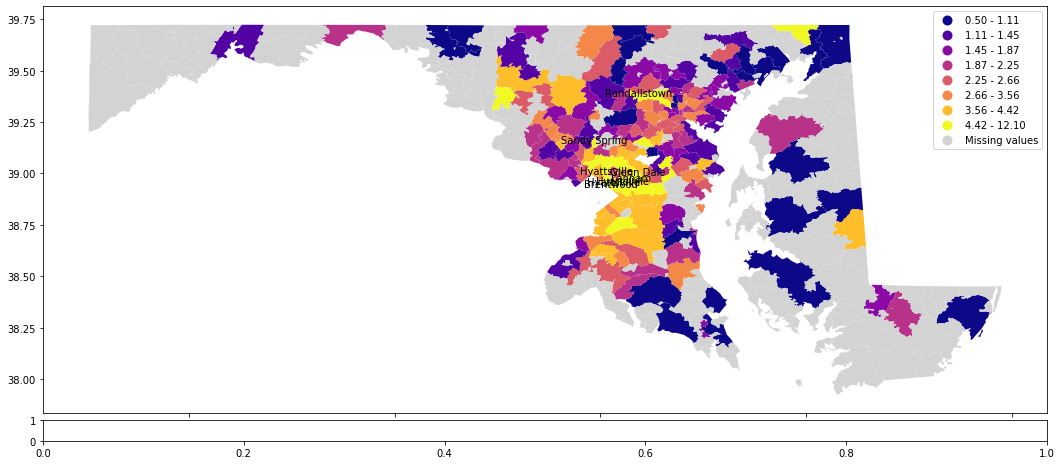

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(18,9))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
zplot = zips.plot(column='density',
                  legend=True,
                  figsize=(32,24),
                  cmap='plasma',
                  scheme='quantiles', k=8,
                  ax=ax, cax=cax,
                  #legend_kwds={
                  #  'label': "Cases / 1000",
                  #  'orientation': "horizontal"  
                  #},
                  missing_kwds={
                      "color": "lightgrey",
                      "label": "Missing values"
                  })


#cities_plot = cities_df.plot(ax=zplot,marker='o',color='white',markersize=15)
#_ = cities_df.apply(lambda x: cities_plot.annotate(s=x.City, 
#                                                   xy=x.geometry.centroid.coords[0], 
#                                                   ha='center', color='black',weight='bold'),
#                    axis=1)

#cities_plot = top_zips \
#    .plot(ax=zplot,color='black')
_ = top_zips \
    .apply(lambda x: zplot.annotate(s=x.City, 
                                    xy=x.geometry.centroid.coords[0], 
                                    ha='center', color='black',),
                    axis=1)
today = datetime.date.today().strftime('%Y-%m-%d')

plt.savefig('%s-MD-density.png' % today)

    ZIPCODE          City    density  cases
324   20860  Sandy Spring  12.103506   29.0
237   20784   Hyattsville   6.587660  194.0
149   20706        Lanham   6.332058  245.0
469   20722     Brentwood   6.303625   36.0
104   20783   Hyattsville   6.249017  278.0
244   20769    Glenn Dale   6.056935   40.0
245   21133  Randallstown   5.767051  173.0
173   20781   Hyattsville   5.506993   63.0
223   20785   Hyattsville   5.506105  193.0
302   20623    Cheltenham   5.466472   15.0
    ZIPCODE      City   density  cases
112   21122  Pasadena  1.386688   84.0


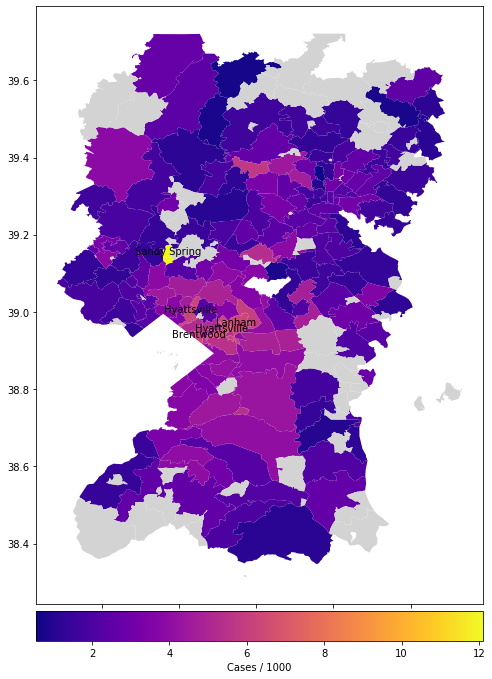

In [15]:
aa_top_zips = zips.cx[-76.488142-0.7:-76.488142+0.1, 38.978132-0.5:38.978132+0.6][['ZIPCODE','City','density','cases','geometry']] \
    .dropna() \
    .sort_values('density',ascending=False)
print(aa_top_zips[['ZIPCODE','City','density','cases']].head(n=10))
print(aa_top_zips.loc[aa_top_zips['ZIPCODE'] == '21122'][['ZIPCODE','City','density','cases']])

fig, ax = plt.subplots(1, 1, figsize=(8,16))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
zplot = zips.cx[-76.488142-0.7:-76.488142+0.1, 38.978132-0.5:38.978132+0.6].plot(
    column='density',
                  legend=True,
                  cmap='plasma',
                  figsize=(16,12),
                  ax=ax, cax=cax,
                  #scheme='quantiles',k=8,
                  legend_kwds={
                    'label': "Cases / 1000",
                    'orientation': "horizontal"  
                  },
                  missing_kwds={
                      "color": "lightgrey",
                      "label": "Missing values"
                  })

_ = aa_top_zips.head(n=5).apply(lambda x: zplot.annotate(s=x.City, 
                                                   xy=x.geometry.centroid.coords[0], 
                                                   ha='center', color='black',),
                    axis=1)